# Tutorial of implementing Drop out
mnist image를 분류하는 Convolution Neural Network에 Drop out을 적용하는 간단한 example

Drop out paper : http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

### Setup

In [1]:
import os, sys
import shutil 
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data # load mnist dataset
mnist = input_data.read_data_sets(train_dir = './MNIST_data', one_hot = True, reshape = True, seed = 777)

Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz


### Define MnistCNN class
conv-conv-max pool-conv-conv-max pool-fc-fc

In [2]:
'''
Drop out의 구현을 위해서는 tf.nn module에 있는 tf.nn.dropout을 활용한다. tf.nn.dropout의 wrapper로 
tf.layers.dropout이 있지만 해당 api는 default rate가 정해져있고, dropout을 걸지 안 걸지를 결정하기위해서
training argument가 존재하는데, 두 가지를 다 조절하려면 두 개의 tf.placeholder가 필요하기 때문에 개인 선호에 의해서
tf.nn.dropout을 활용한다.(tf.nn.dropout은 keep_prob argument 하나만 존재)
일반적인 Convolution Neural Network에 적용할 때는, 마지막 output layer (label의 개수와 같은 fc layer) 전의 fc layer에
Drop out을 적용한다.
(Convolution Neural Network의 Filter에 적용하는 논문도 있다. 이는 drop connect 논문과 비슷한 발상에서 나온 것 같다)
'''
class MnistCNN:
    def __init__(self, activation_fn = tf.nn.relu, initializer = tf.contrib.layers.variance_scaling_initializer(),
                 l2_scale = 0.01):
        
        with tf.variable_scope('input_layer'):
            self._x = tf.placeholder(dtype = tf.float32, shape = [None,784])
            self._ximg = tf.reshape(tensor = self._x, shape = [-1,28,28,1])
            self._y = tf.placeholder(dtype = tf.float32, shape = [None,10])
            self._keep_prob = tf.placeholder(dtype = tf.float32)
            
        with tf.variable_scope('conv_layer1'):
            _conv_pre = tf.layers.conv2d(inputs = self._ximg, filters = 64, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_relu = activation_fn(_conv_pre)
            
        with tf.variable_scope('conv_layer2'):
            _conv_pre = tf.layers.conv2d(inputs = _conv_relu, filters = 64, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_relu = activation_fn(_conv_pre)
            
        with tf.variable_scope('max_pool1'):
            _pooled = tf.layers.max_pooling2d(inputs = _conv_relu, pool_size = [2,2], strides = 2)
            
        with tf.variable_scope('conv_layer3'):
            _conv_pre = tf.layers.conv2d(inputs = _pooled, filters = 128, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_relu = activation_fn(_conv_pre)
            
        with tf.variable_scope('conv_layer4'):
            _conv_pre = tf.layers.conv2d(inputs = _conv_relu, filters = 128, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_relu = activation_fn(_conv_pre)
            
        with tf.variable_scope('max_pool2'):
            _pooled = tf.layers.max_pooling2d(inputs = _conv_relu, pool_size = [2,2], strides = 2)
        
        with tf.variable_scope('dense_layer1'):
            _pooled_vector = tf.reshape(tensor = _pooled, shape = [-1,np.cumprod(_pooled.get_shape().as_list()[-3:])[-1]])
            _fc_pre = tf.layers.dense(inputs = _pooled_vector, units = 1024, kernel_initializer = initializer,
                                  kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            _fc_relu = activation_fn(_fc_pre)
            _fc_relu = tf.nn.dropout(x = _fc_relu, keep_prob = self._keep_prob)
            
        with tf.variable_scope('output_layer'):
            self._score = tf.layers.dense(inputs = _fc_relu, units = 10, kernel_initializer = initializer,
                                          kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            
        with tf.variable_scope('loss'):
            _ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self._score, labels = self._y))
            _reg_term = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
            self._total_loss = _ce_loss +  _reg_term

                
        with tf.variable_scope('predict'):
            self._prediction = tf.argmax(input = self._score, axis = 1)
    
    def predict(self, sess, x_data, keep_prob = 1.):
        feed_predict = {self._x : x_data, self._keep_prob : keep_prob}
        return sess.run(fetches = self._prediction, feed_dict = feed_predict)

### Define Solver class

In [3]:
class Solver:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer, var_list = None):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        self._training_op = self._optimizer.minimize(loss = self._model._total_loss, var_list = var_list)
    
    def train(self, sess, x_data, y_data, lr, keep_prob = .5):
        feed_train = {self._model._x : x_data, self._model._y : y_data, self._lr : lr,
                      self._model._keep_prob : keep_prob}
        return sess.run(fetches = [self._training_op, self._model._total_loss], feed_dict = feed_train)
            
    def evaluate(self, sess, x_data, y_data, keep_prob = 1.):
        feed_loss = {self._model._x : x_data, self._model._y : y_data, self._model._keep_prob : keep_prob}
        return sess.run(fetches = self._model._total_loss, feed_dict = feed_loss)

### Generate CNN model and Adam solver### 

In [4]:
sess = tf.Session()
mnist_classifier = MnistCNN()

In [5]:
adam_solver = Solver(model = mnist_classifier)

### Training

In [6]:
# Hypear-parameters
batch_size = 100
n_epochs = 10
best_loss = np.infty
max_checks_without_progress = 15
checks_without_progress = 0
tr_loss_history = []
val_loss_history = []

In [7]:
sess.run(tf.global_variables_initializer())

In [8]:
for epoch in range(n_epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    total_batch = int(mnist.train.num_examples / batch_size)
    
    for step in range(total_batch):
        
        batch_xs, batch_ys = mnist.train.next_batch(batch_size = batch_size)
        val_xs, val_ys = mnist.validation.next_batch(batch_size = batch_size)
        _, tr_loss = adam_solver.train(sess = sess, x_data = batch_xs, y_data = batch_ys, lr = 1e-3, keep_prob = .5)
        val_loss = adam_solver.evaluate(sess = sess, x_data = val_xs, y_data = val_ys, keep_prob = 1)
        
        avg_tr_loss += tr_loss / total_batch
        avg_val_loss += val_loss / total_batch
        if step % 100 == 0:
            print('step : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(step, tr_loss, val_loss))
    
    print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))
    tr_loss_history.append(avg_tr_loss)
    val_loss_history.append(avg_val_loss)
    
     # early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        checks_without_progress = 0
    else:
        checks_without_progress += 1
        if checks_without_progress > max_checks_without_progress:
            print('Early stopping')
            break

step :   0, tr_loss : 17.423, val_loss : 21.375
step : 100, tr_loss : 3.446, val_loss : 3.483
step : 200, tr_loss : 1.886, val_loss : 1.836
step : 300, tr_loss : 1.265, val_loss : 1.269
step : 400, tr_loss : 0.894, val_loss : 0.996
step : 500, tr_loss : 0.744, val_loss : 0.723
epoch :   0, tr_loss : 2.493, val_loss : 2.422
step :   0, tr_loss : 0.694, val_loss : 0.737
step : 100, tr_loss : 0.577, val_loss : 0.590
step : 200, tr_loss : 0.454, val_loss : 0.454
step : 300, tr_loss : 0.468, val_loss : 0.478
step : 400, tr_loss : 0.370, val_loss : 0.361
step : 500, tr_loss : 0.317, val_loss : 0.388
epoch :   1, tr_loss : 0.488, val_loss : 0.461
step :   0, tr_loss : 0.351, val_loss : 0.377
step : 100, tr_loss : 0.323, val_loss : 0.360
step : 200, tr_loss : 0.275, val_loss : 0.270
step : 300, tr_loss : 0.303, val_loss : 0.257
step : 400, tr_loss : 0.315, val_loss : 0.312
step : 500, tr_loss : 0.263, val_loss : 0.273
epoch :   2, tr_loss : 0.335, val_loss : 0.311
step :   0, tr_loss : 0.295, 

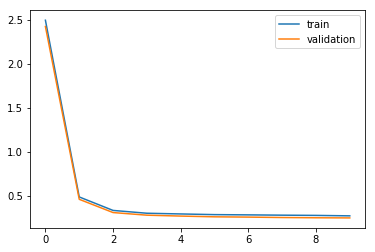

In [9]:
plt.plot(tr_loss_history, label = 'train')
plt.plot(val_loss_history, label = 'validation')
plt.legend()

In [10]:
hat = mnist_classifier.predict(sess=sess, x_data=mnist.test.images, keep_prob=1.)

In [11]:
print('accuracy : {:.2%}'.format(np.mean(np.argmax(mnist.test.labels, axis = 1) == hat)))

accuracy : 97.85%
